# <font color='#eb3483'> Logistic Regression </font>

In this module, we'll be exploring how to build a logistic regression model using scikit-learn. Remember, logistic regression is a binary classification algorithm, so instead of predicting a number (regression) or a group of labels (i.e. multi-class classification) we'll be predicting either true (1) or false (0). Let's start by importing our usual toolkit.

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

ImportError: numpy.core.multiarray failed to import

## <font color='#eb3483'> Breast Cancer Data </font>

We are going to use the [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). It is a dataset that contains measurements taken on breast cancer cell images. The goal of the dataset is to predict whether a cancer tumor is benign or malignant.

In [2]:
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()
#loads the features of the data
cancer_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
# description of the dataset cancer_data

print(cancer_data["DESCR"])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

This dataset is a binary classification problem, where the target variable indicates whether a tumor is malignant or benign, encoded as 0 and 1, respectively. The features are measurements taken from the cell images, mostly measures of the cell nucleii.

In [4]:
cancer_data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [5]:
# compute the value counts of the target variable in the cancer_data dataset: how many are malignant and benign?

pd.Series(cancer_data["target"]).value_counts(normalize=True).sort_index()


0    0.372583
1    0.627417
Name: proportion, dtype: float64

In this dataset, 62.7% of tumors are benign and 37.3% are malignant.

In [6]:
cancer_data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [7]:
X = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y = cancer_data.target

There are lots of features in this dataset. Let's limit ourselves to just the "mean" features:

In [8]:
# Filter columns that start with 'mean'
mean_cols = [col for col in X.columns if col.startswith('mean')]

# Select only the columns starting with 'mean'
X_mean = X[mean_cols]

In [9]:
X_mean

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883
...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016


Let's split our dataset into training and test sets:

In [15]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('The training set has', X_train.shape[0], 'rows')
print('The test set has', X_test.shape[0], 'rows')

The training set has 455 rows
The test set has 114 rows


Shortly, we will be fitting our first logistic regression model. From an optimisation point of view, this involves finding the $\beta$ coefficients that minimise the cross-entropy loss function. The internal procedures that perform this operation work best if the features are ***standardized***; that is, for each feature, we subtract its mean and divide by its standard deviation. This ensures that all features have the same scale, but doesn't change the nature of the relationship between the features and the target variable.

We can do this in `sklearn` by instantiating a `StandardScaler` object from the `preprocessing` submodule. We use the `fit_transform` method to compute the means and standard deviations for the training data and then apply the transformation to the training data. We then use the `transform` method to standardize the test data using the means and standard deviations estimated from the training set.

<font color='#eb3483'> **Question:** </font> **Why do we not apply the `fit_transform` method on the test set?**

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## <font color='#eb3483'> Logistic Regression in Scikit-Learn </font>

In this section, we will fit a logistic regression model and use it to make predictions. Take note of how similar the process is to linear regression. This is the case for all estimators in `sklearn` and is the primary reason for the module's popularity. Even though the models are very different, the training and prediction steps look almost identical in `sklearn`!



In [17]:
from sklearn.linear_model import LogisticRegression
?LogisticRegression

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

In [18]:
# Create a logistic regression model
model = LogisticRegression(max_iter=200)

model.fit(X_train, y_train)

# Train the model on the standardized training data


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

We can examine the estimated coefficients in the usual way. Note that because we standardized our features, the absolute values of the coefficients give us a measure of feature importance:

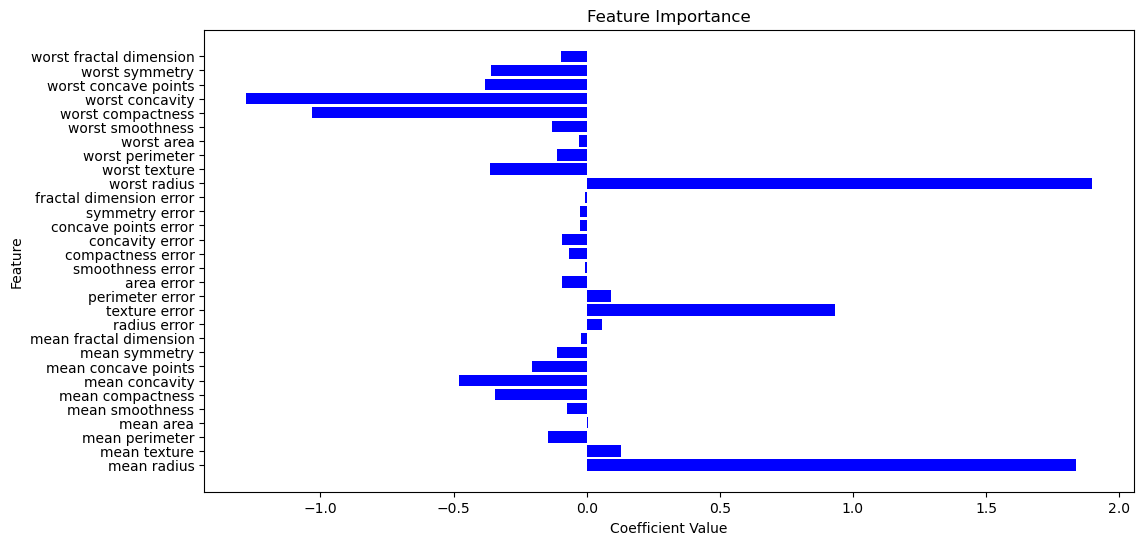

In [19]:
#feature importance

import matplotlib.pyplot as plt

# Get the coefficients
coefficients = model.coef_[0]

# Plot the coefficients
plt.figure(figsize=(12, 6))
plt.barh(range(len(cancer_data.feature_names)), coefficients, color='b', align='center')
plt.yticks(range(len(cancer_data.feature_names)), cancer_data.feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

<font color='#eb3483'> **How do you interpret this chart?**

Let's now make some predictions on the test data:

We see that the `predict` method directly outputs the predicted class (0 or 1), assuming a classification threshold of 0.5. If we want to see the underlying probabilities, we can use the `predict_proba` method:

In [1]:
y_pred = model.predict(X_test)
y_pred[:10]

NameError: name 'model' is not defined

In [ ]:
y_prob = model.predict_proba(X_test)
y_prob[:10]
#probability that it is casted as a 1 or a 0
# why are there two columns of results here?

## <font color='#eb3483'> Model Evaluation </font>

In binary classification, we have:

- *Positive cases*: Cases of labelled as 1 (benign cancers)
- *Negative cases*: Cases of labelled as 0 (malignant cancers)

Since actual positive cases can be classified correctly as positive or incorrectly as negative, and actual negative cases can be classified incorrectly as positive or correctly as negative, we have four possible scenarios:

- *True Positives* (TP): the cancers that are benign and are correctly classified as benign
- *False Positives* (FP): malignant cancers that are incorrectly classified as benign
- *True Negatives* (TN): malignant cancers that are correctly classified as malignant
- *False Negatives* (FN): benign cancers that are incorrectly classified as malignant

### <font color='#eb3483'> **Confusion Matrix** </font>

We can use a confusion matrix to easily examine how a classifier has performed in each one of these categories. The `metrics` submodule in `sklearn` has a `confusion_matrix` function. NB: Read the documentation (`?confusion_matrix`) to see what the rows and columns represent.

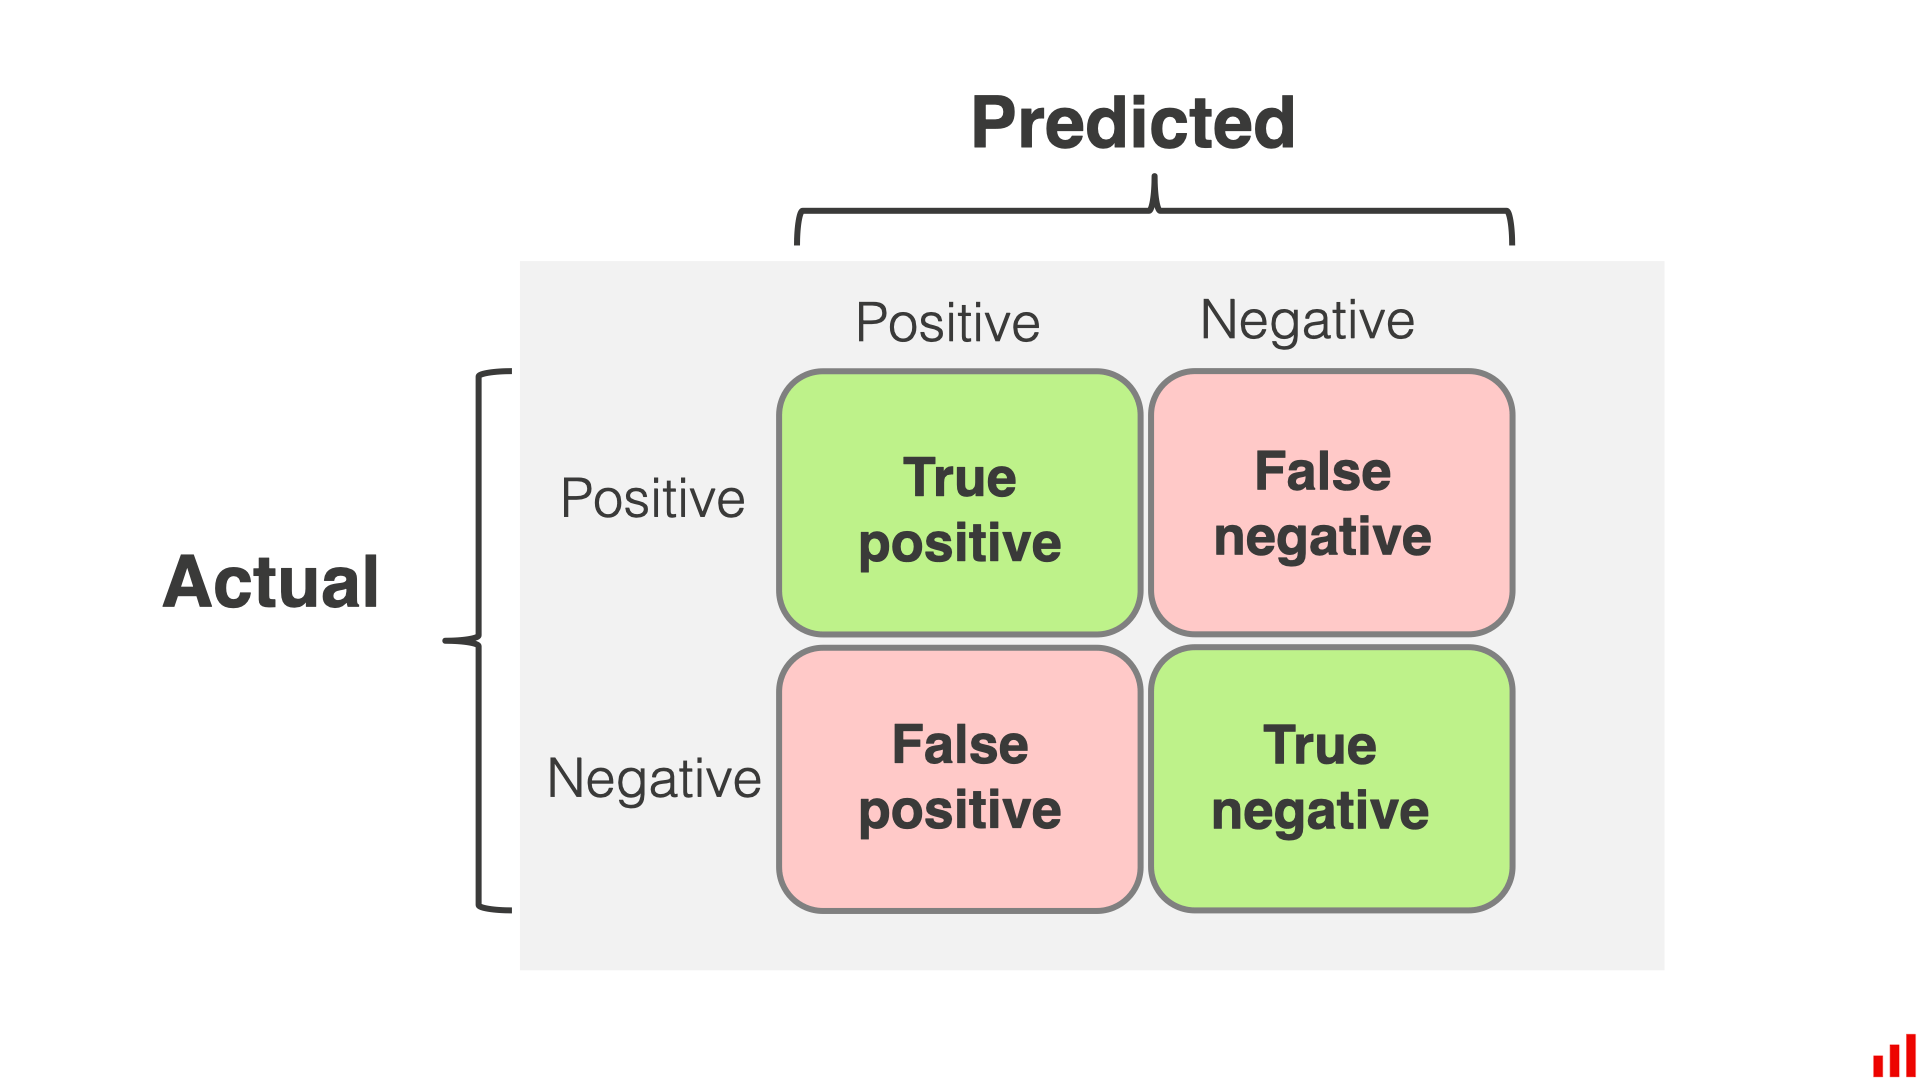

In [3]:

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot a confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


ImportError: numpy.core.multiarray failed to import

### <font color='#eb3483'> Evaluation Metrics for Classification </font>

#### <font color='#eb3483'> Classification Accuracy </font>

Accuracy is a general measure of the model's performance. It simply measures the percentage of cases correctly classified.

$$\text{Accuracy}=\frac{\text{Number of correctly classified observations}}{\text{Total number of observations}}= \frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}}$$

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#### <font color='#eb3483'> Precision </font>

Precision measures the accuracy of a model's positive predictions - when a model says a case is positive, how confident can we be that it is correct?

$$\text{Precision}=\frac{\text{Number of positive cases correctly classified}}{\text{Number of cases classified as positive}}= \frac{\text{TP}}{\text{TP}+\text{FP}}$$

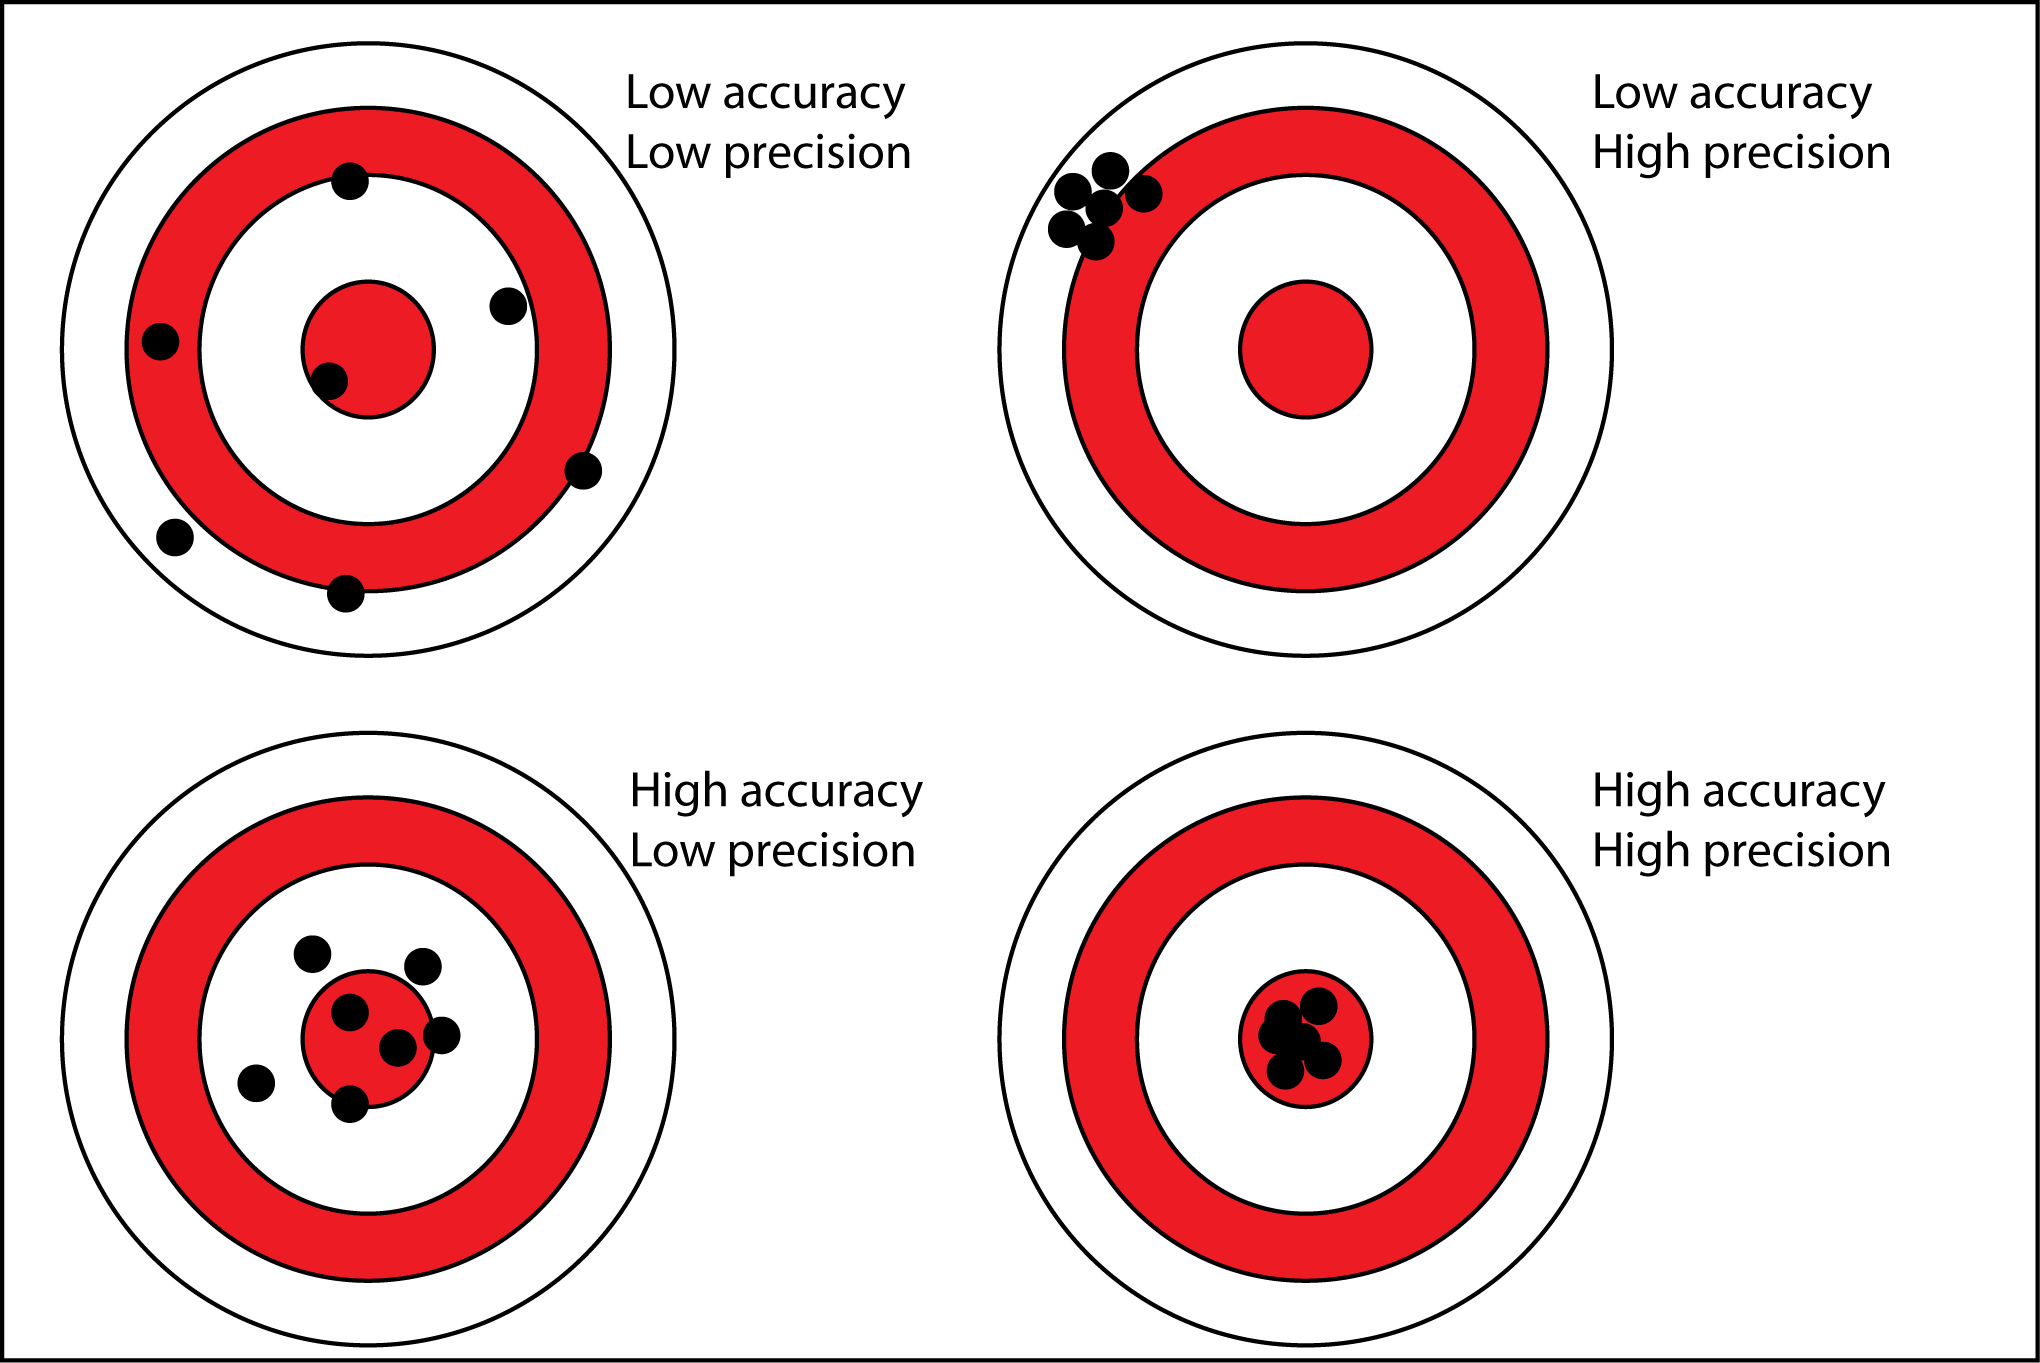

In [ ]:
precision = metrics.precision_score(y_test, y_pred)
print("Precision:", precision)

#### <font color='#eb3483'> Recall/ True Positive Rate (TPR) </font>

Recall gives us an idea of the model's ability to find (detect) the true positive cases.

$$\text{Recall}=\frac{\text{Number of positive cases correctly classified}}{\text{Number of positive classes}}= \frac{\text{TP}}{\text{TP}+\text{FN}}$$

In [ ]:
recall = metrics.recall_score(y_test, y_pred)
print("Recall:", recall)

**What is the difference between precision and recall?**

#### <font color='#eb3483'> ROC Curve and AUC </font>

The receiver operating characteristics [(ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a curve used to evaluate how recall (TPR) and the false positive rate (FPR) vary as we change the classification threshold (that is, the theshold we apply to the probabilities to determine which class a case belongs to). We have already defined the TPR above. The FPR is defined as the proportion of true negatives that are incorrected classified as positive:


$$\text{False positive rate} = \frac{\text{Number of negative cases incorrectly classified}}{\text{Total number of negative cases}} = \frac{\text{FP}}{\text{FP}+\text{TN}} $$


The ROC curve shows you how good your model is at distinguishing between patients with the disease and those without, across all possible threshold values.

A curve that is closer to the top-left corner of the plot is considered better, as it indicates higher true positive rates and lower false positive rates across different thresholds.

If the ROC curve is a diagonal line from the bottom-left to the top-right, it means the model is not much better than random guessing.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc

**What does the ROC value mean?**